<a href="https://colab.research.google.com/github/pagand/model_optimze_vessel/blob/main/Modeling/NRC_pytorch_MLP_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pytorch mlp for regression
from numpy import vstack
from numpy import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor, device, cuda
from torch.nn import Linear
from torch.nn import Sigmoid, ReLU
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns # for visualization
from torch.nn import Sigmoid, ReLU
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns # for visualization
import numpy as np
import matplotlib.pylab as plt

In [ ]:
from torch.utils import data
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path, normalized = False):
        # load the csv file as a dataframe
        df = read_csv(path, header=0, index_col=0)
        # store the inputs and outputs
        self.MinOut = df.iloc[:, -1].min()
        self.MaxOut = df.iloc[:, -1].max()
        
        if normalized:
          for column in df.columns[:]:
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())  

        
        self.X = df.values[:, :-1].astype('float32')
        self.y = df.values[:, -1].astype('float32')
        
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))


        
  

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [ ]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        
        self.hidden1 = Linear(n_inputs, 30)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        # second hidden layer
        self.hidden2 = Linear(30, 20)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        # third hidden layer and output
        self.hidden3 = Linear(20, 1)
        xavier_uniform_(self.hidden3.weight)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # # third hidden layer and output
        X = self.hidden3(X)
        return X

In [ ]:
# prepare the dataset
def prepare_data(path, normalized):
    # load the dataset
    dataset = CSVDataset(path, normalized )# normalize input and output
    
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    MinOut = dataset.MinOut
    MaxOut = dataset.MaxOut
    

    return train_dl, test_dl, MinOut, MaxOut

In [ ]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = MSELoss()
    #optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = Adam(model.parameters(), lr=0.005)

    # enumerate epochs
    for epoch in range(200):
        if epoch % 10 ==0  and epoch:
              print("Epoch %d completed" %epoch)
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # convert to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # if i == 100 or i == 500 or i ==900:
            #   print ([yhat])
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [ ]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # convert to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

In [ ]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat


In [ ]:
# Access GPU ( before in google colab try to change Runtime>change runtime time>hardware acceleator > GPU)
device = device('cuda' if cuda.is_available() else 'cpu')
print("current device is {}".format(device))
# prepare the data

path = '/content/drive/MyDrive/in_out_NN.csv'
train_dl, test_dl, MinOut, MaxOut = prepare_data(path,normalized = True)

print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(10).to(device) # number of inputs, run in the device
# train the model
print("start training ...")
train_model(train_dl, model)

# train overal error
mse = evaluate_model(train_dl, model)
scaler = (MaxOut-MinOut) # 1 if no normalization, otherwise should put to denormalize

actual_mse = mse * (scaler)**2
print('train error:: MSE: %.3f, RMSE: %.3f' % (actual_mse, sqrt(actual_mse)))


# evaluate the model
print("start evaluation ...")
mse = evaluate_model(test_dl, model)

actual_mse = mse * (scaler)**2
print('test error:: MSE: %.3f, RMSE: %.3f' % (actual_mse, sqrt(actual_mse)))
# make a single prediction 


current device is cuda
212547 104688
start training ...
Epoch 10 completed
Epoch 20 completed
Epoch 30 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

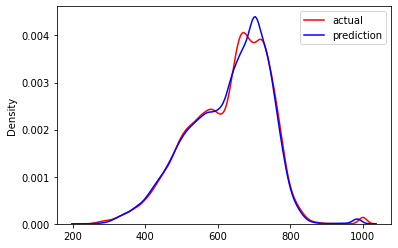

In [ ]:

import matplotlib.pylab as plt

y_test = np.zeros(len(test_dl.dataset))
y_pred = np.zeros(len(test_dl.dataset))
A = np.array(train_dl.dataset)

for i in range(len(test_dl.dataset)):
   y_test[i] =  A[i][1]*scaler+ MinOut
   y_pred[i] = predict(A[i][0], model) *scaler + MinOut


plt.figure("Test Plots")
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)
plt.legend()